# Breast Cancer Classification

### Problem Statement
* In this project, we intend to apply Deep Learning techniques on a multi-class classification task which identifies the cancer type based on the images obtained for analysis. The dataset used for our project is the BreakHis dataset which is a breast cancer histopathology image database. It contains around 9,100 microscopic images of different types of breast cancer tissues. In this project, we plan to implement Convolutional Neural Network (CNN) model to recognize these images and classify them based on their cancer type. CNN is a deep learning model that derives an image’s features and practices these features to analyze an image.
    
    
    
* **Keywords:** Multi-class classification, CNN, BreakHis dataset, breast cancer
	

## Data Collection
* Source(url): https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/
* Short Description : The Breast Cancer Histopathological Image Classification (BreakHis) is  composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients using different magnifying factors (40X, 100X, 200X, and 400X). To date, it contains 2,480  benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format). 

* Keywords: Breast tumor, microscopic images, magnifying factors, benign, malignant

### Required packages

* Import required packages

In [1]:
import numpy as np 
import pandas as pd 
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image
import cv2
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from numpy.random import seed
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [3]:

print("Python version:",tf. __version__) 
print("Keras version:", keras.__version__)


Python version: 2.8.0
Keras version: 2.8.0


In [4]:
print("Number of GPUs available : ",len(tf.config.list_physical_devices('GPU')))

Number of GPUs available :  1


First , we set the seed so that our outputs are always consistent

In [5]:
# set a seed for a reproducible results 
seed(85)
tf.random.set_seed(85)

### Functions 

In [6]:
import random
from keras.preprocessing import image
import matplotlib.pyplot as plt

img = []
def load_image(tar_dir):
    fnames = [os.path.join(tar_dir, fname) for fname in os.listdir(tar_dir)]
       
    m= random.randint(0,len(fnames)-1)

    img_path = fnames[m]
   
    # Read the image 
    img = image.load_img(img_path, target_size= (150, 150))
    #print(img.size)
               
    return(img)
    
# Function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(12)
    f.suptitle(captions)
    i=0
    key_list=list(images.keys())
    for ax,image in zip(axes, list(images.values())):
        ax.imshow(image, cmap)
        ax.set_title(key_list[i])
        i=i+1

        
#Function to read each image, assign label to image based on the directory it is present . 
#Then create a list containing the images and its labels.
import glob

def label_images(dir, dict_type):
    images_list=[]
    for key in dict_type:
        p = dir+'/'+ key
        #print(p)
        for im in glob.glob(p + '/**/*.png',recursive = True):
            im_array = cv2.imread(im)
            label = key
            #print(label)
            # Create a list containing all the images and its labels
            images_list.append([im_array,label])
            
    
    print(len(images_list))
    return images_list



In [7]:
# Function to plot accuracy and loss of the model

def accuracy_loss_plot(history):
    acc=history.history['acc']
    val_acc = history.history['val_acc']
    
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    accuracy = acc[-1]  # oraccuracy= np.mean(acc) 
    accuracy_percentage = str("{:.3f}".format(accuracy))   

    val_accuracy = val_acc[-1]  # or val_accuracy=np.mean(val_acc) 
    val_accuracy_percentage =  str("{:.3f}".format(val_accuracy))
                                                           
    plt.legend(['Train Accuracy: '+ accuracy_percentage, 'Validation Accuracy: '+ val_accuracy_percentage], loc='upper left')
    plt.show()
    
    
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    loss = loss[-1] # np.mean(history['loss'])
    loss_percentage =  str("{:.3f}".format(loss))   
   
    val_loss = val_loss[-1] #np.mean(history['val_loss'])
    val_loss_percentage =  str("{:.3f}".format(val_loss))
    
    plt.legend(['Training Loss: '+loss_percentage, 'Validation Loss: '+val_loss_percentage], loc='upper left')
    plt.show()
    
   

## Data Exploration

We need to understand the data before we preprocess the data and develop the model. Here, we will explore the data to understand the different types of cancers and the number of images availble in each type.

In [8]:
import os
# The path to the directory where the original dataset was uncompressed

original_dataset_dir = os.getcwd()
#original_dataset_dir = r'D:\BreaKHis_v1.tar'
print("Original_dataset_dir: ", original_dataset_dir)

Original_dataset_dir:  C:\Users\laksh\Documents\DAAN570 - Deep Learning\Project


 We need to understand the number of images in each of the different classes and should check for imbalance in the dataset.

In [9]:
import os
from glob import glob

breakHis_dir = os.path.join(original_dataset_dir, 'BreaKHis_v1')

types=['benign', 'malignant']

benign_dict = {'adenosis':0,'fibroadenoma':0,'phyllodes_tumor':0,'tubular_adenoma':0}
malignant_dict = {'ductal_carcinoma':0,'lobular_carcinoma':0,'mucinous_carcinoma':0,'papillary_carcinoma':0}

BASE_PATH= breakHis_dir + "\histology_slides\\breast\\"
#print(BASE_PATH)

benign_imgs_to_plot={}
malignant_imgs_to_plot={}

for type in types:
    path=BASE_PATH+type+"\SOB\\"
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.png'))]
   # print(path)
    print("============")
    print("Number of {t} images:".format(t=type), len(result))
    print("============")
    if (type == 'benign'):
        #for sub_types in benign :
        for key in benign_dict:
            sub_types = key 
            s_path = path + sub_types
            #print(s_path)
            bn = [y for x in os.walk(s_path) for y in glob(os.path.join(x[0], '*.png'))]
            print("{st}:".format(st=sub_types),len(bn))               
            benign_dict[key] = len(bn)
            
            if (key not in benign_imgs_to_plot):
                benign_imgs_to_plot[key] = load_image(os.path.dirname(bn[0]))
    else:
        #for sub_types in malignant:
        for key in malignant_dict:
            sub_types = key 
            s_path = path + sub_types
            #print(s_path)
            bn = [y for x in os.walk(s_path) for y in glob(os.path.join(x[0], '*.png'))]
            print("{st}:".format(st=sub_types),len(bn))
            malignant_dict[key] = len(bn)
            
            if (key not in malignant_imgs_to_plot):
                malignant_imgs_to_plot[key] = load_image(os.path.dirname(bn[0]))



Number of benign images: 2480
adenosis: 444
fibroadenoma: 1014
phyllodes_tumor: 453
tubular_adenoma: 569
Number of malignant images: 5429
ductal_carcinoma: 3451
lobular_carcinoma: 626
mucinous_carcinoma: 792
papillary_carcinoma: 560


In [10]:
# Store the count of each cancer type in a dictionary

print(benign_dict)
print(malignant_dict)
#print(benign_dict['adenosis'])

{'adenosis': 444, 'fibroadenoma': 1014, 'phyllodes_tumor': 453, 'tubular_adenoma': 569}
{'ductal_carcinoma': 3451, 'lobular_carcinoma': 626, 'mucinous_carcinoma': 792, 'papillary_carcinoma': 560}


<BarContainer object of 4 artists>

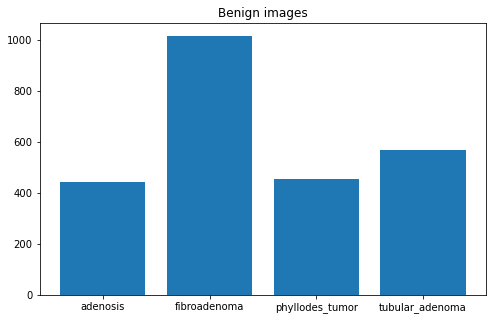

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,5))
plt.title("Benign images")
plt.bar(benign_dict.keys(),benign_dict.values())

<BarContainer object of 4 artists>

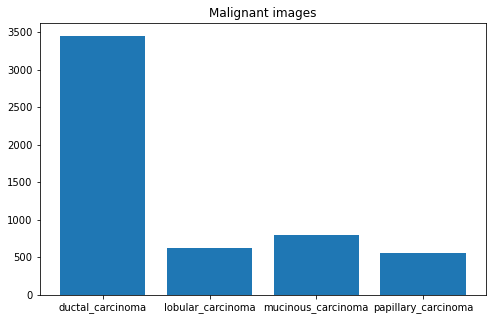

In [12]:
plt.figure(figsize = (8,5))
plt.title("Malignant images")
plt.bar(malignant_dict.keys(),malignant_dict.values())

We understand that the data is highly imbalanced. The number of malignant images are lot more than the number of beningn images. 
Moreover, there is a huge variation between individual cancer types. For instance, ductal_carcinoma has around 3451 images, where as adenosis has only 444. This highly imbalanced data will affect our modelling accuracy.

Now, let's look at some of the images from each of the different cancer types.

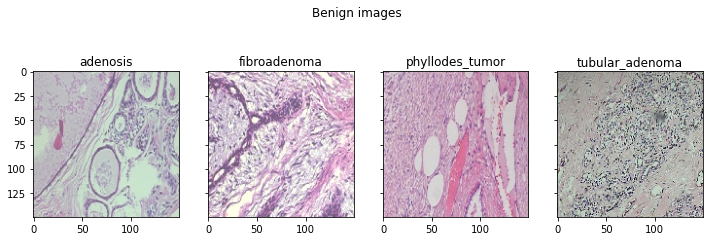

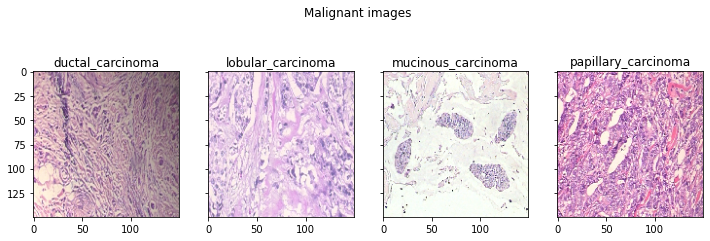

In [13]:
#Plot different cancer images

plot_image(benign_imgs_to_plot,captions = 'Benign images')

plot_image(malignant_imgs_to_plot,captions = 'Malignant images')


In [14]:
#Loop through all the images and assign a label to each image based on the directory in which the image is present
import glob
import cv2

print(BASE_PATH)
combined_input_img=[]
for type in types:
    path=BASE_PATH+ type +"\SOB"
    
    # Pass the benign cancer types if the base path contain benign, otherwise pass the malignant cancer types
    dict_type = benign_dict if type == 'benign' else malignant_dict
    
    #Combining all the images into a single list
    combined_input_img += label_images(path,dict_type)
    
print(len(combined_input_img))

C:\Users\laksh\Documents\DAAN570 - Deep Learning\Project\BreaKHis_v1\histology_slides\breast\
2480
5429
7909


In [15]:
# Check the total input image count
print(len(combined_input_img))

7909


In [16]:
#Create a tensor to store the  images and labels 

from pandas import DataFrame

image_df = DataFrame(combined_input_img,columns= ['image', 'label'])


In [17]:
#Split the input images and target labels

X_all = image_df['image']
y = image_df['label']

In [18]:
#Size of input images

X_all[5].shape

(460, 700, 3)

We can see that the input images are of size ( 460,700,3)

In [19]:
#The target variable is divided intp 8 different classes

print("Number of different types of cancer are ",len(y.unique()))
print("Different types of cancer are ",y.unique())

Number of different types of cancer are  8
Different types of cancer are  ['adenosis' 'fibroadenoma' 'phyllodes_tumor' 'tubular_adenoma'
 'ductal_carcinoma' 'lobular_carcinoma' 'mucinous_carcinoma'
 'papillary_carcinoma']


### Split the data to training and testing dataset

Next, we create a new directory which will have different folders for Train, Validation and Test. In each of the directories we 
will create sub folders for the each of the different cancer types.

The images are split in the ratio of 80:20 for train and test. The train dataset is agin divided into train and validation in the ration 80 :20.

In [20]:

def create_subdir(dir_path):
    # Directory with adenosis pictures
    a_dir = os.path.join(dir_path, 'adenosis')
    os.mkdir(a_dir)

    # Directory with fibroadenoma pictures
    f_dir = os.path.join(dir_path, 'fibroadenoma')
    os.mkdir(f_dir)

    # Directory with phyllodes_tumor pictures
    pt_dir = os.path.join(dir_path, 'phyllodes_tumor')
    os.mkdir(pt_dir)

    # Directory with tubular_adenoma pictures
    ta_dir = os.path.join(dir_path, 'tubular_adenoma')
    os.mkdir(ta_dir)

    # Directory with ductal_carcinoma pictures
    dc_dir = os.path.join(dir_path, 'ductal_carcinoma')
    os.mkdir(dc_dir)

    # Directory with lobular_carcinoma pictures
    lc_dir = os.path.join(dir_path, 'lobular_carcinoma')
    os.mkdir(lc_dir)

    # Directory with mucinous_carcinoma pictures
    mc_dir = os.path.join(dir_path, 'mucinous_carcinoma')
    os.mkdir(mc_dir)

    # Directory with papillary_carcinoma pictures
    pc_dir = os.path.join(dir_path, 'papillary_carcinoma')
    os.mkdir(pc_dir)


# The directory where we will store our new dataset
base_dir = os.path.join(original_dataset_dir,'Breast_cancer_dataset')


#If the directories and sub folders are already created, we don't have to create it again.
if os.path.exists(base_dir):
    print("base_dir : ", base_dir)
    train_dir = os.path.join(base_dir, 'train')
    train_augment_dir = os.path.join(base_dir, 'trainaugment')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')
else:
    os.mkdir(base_dir) 
    
    # Directories for our training, validation and test splits
    
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
    train_augment_dir = os.path.join(base_dir, 'trainaugment')
    os.mkdir(train_augment_dir)
    validation_dir = os.path.join(base_dir, 'validation')
    os.mkdir(validation_dir)
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

    #Training directory
    create_subdir(train_dir)
  
    #Training directory with augmented images
    create_subdir(train_augment_dir)
    
    # Validation directory
    create_subdir(validation_dir)
    
    # Test directory
    create_subdir(test_dir)


In [21]:
print("Train dir: ",train_dir)
print("Validation dir: ", validation_dir)
print("Test dir :", test_dir)
print("Augmented Train dir: ",train_augment_dir)

Train dir:  C:\Users\laksh\Documents\DAAN570 - Deep Learning\Project\Breast_cancer_dataset\train
Validation dir:  C:\Users\laksh\Documents\DAAN570 - Deep Learning\Project\Breast_cancer_dataset\validation
Test dir : C:\Users\laksh\Documents\DAAN570 - Deep Learning\Project\Breast_cancer_dataset\test
Augmented Train dir:  C:\Users\laksh\Documents\DAAN570 - Deep Learning\Project\Breast_cancer_dataset\trainaugment


In [22]:
# Use the scikitlean train_test_split function to split the dataset into 80% for training and 20% for testing. 
#Since the data is imbalanced, we used stratify = y to ensure that we take equal amounts of samples from each type for 
#train and test

X_train1,X_test,y_train1,y_test=train_test_split(X_all,y,random_state=0,test_size=0.2,stratify=y)

In [23]:
# Check training and testing datasets sizes

X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((6327,), (1582,), (6327,), (1582,))

In [24]:
# Check precentage of label distribution between training and testing datasets 

y_train1.value_counts()/len(y_train1), y_test.value_counts()/len(y_test)

(ductal_carcinoma       0.436384
 fibroadenoma           0.128181
 mucinous_carcinoma     0.100205
 lobular_carcinoma      0.079184
 tubular_adenoma        0.071914
 papillary_carcinoma    0.070808
 phyllodes_tumor        0.057215
 adenosis               0.056109
 Name: label, dtype: float64,
 ductal_carcinoma       0.436157
 fibroadenoma           0.128319
 mucinous_carcinoma     0.099874
 lobular_carcinoma      0.079014
 tubular_adenoma        0.072061
 papillary_carcinoma    0.070796
 phyllodes_tumor        0.057522
 adenosis               0.056258
 Name: label, dtype: float64)

In [25]:
#Split the train dataset into train and validation datasets in the ratio 80:20

X_train,X_validation,y_train,y_validation=train_test_split(X_train1,y_train1,test_size=0.2,stratify=y_train1)

In [26]:
# Check training and testing datasets sizes

X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((5061,), (1266,), (5061,), (1266,))

In [27]:
# Check precentage of label distribution between training and testing datasets 

y_train.value_counts()/len(y_train), y_validation.value_counts()/len(y_validation)

(ductal_carcinoma       0.436277
 fibroadenoma           0.128236
 mucinous_carcinoma     0.100178
 lobular_carcinoma      0.079233
 tubular_adenoma        0.071923
 papillary_carcinoma    0.070737
 phyllodes_tumor        0.057301
 adenosis               0.056115
 Name: label, dtype: float64,
 ductal_carcinoma       0.436809
 fibroadenoma           0.127962
 mucinous_carcinoma     0.100316
 lobular_carcinoma      0.078989
 tubular_adenoma        0.071880
 papillary_carcinoma    0.071090
 phyllodes_tumor        0.056872
 adenosis               0.056082
 Name: label, dtype: float64)

In [28]:
len_train = X_train.shape[0]
len_val = X_validation.shape[0]
len_test = X_test.shape[0]

In [29]:
print('Total training images:', len_train)
print('Total validation images:', len_val )
print('Total test images:', len_test)

Total training images: 5061
Total validation images: 1266
Total test images: 1582


In [30]:
#Copying images into train dataset

for i in range(0,len(X_train)):  
    img=X_train.iloc[i]
    cv2.imwrite(train_dir + '/'+ y_train.iloc[i] + '/'+str(i)+'.png'  , img)
    

In [31]:
#Copying images into Validation dataset

for i in range(0,len(X_validation)):  
    img=X_validation.iloc[i]
    cv2.imwrite(validation_dir + '/'+ y_validation.iloc[i] + '/'+str(i)+'.png'  , img)


In [32]:
#Copying images into test dataset

for i in range(0,len(X_test)):  
    img=X_test.iloc[i]
    cv2.imwrite(test_dir + '/'+ y_test.iloc[i] + '/'+str(i)+'.png'  , img)


In [33]:
print(os.listdir(train_dir))

['adenosis', 'ductal_carcinoma', 'fibroadenoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma', 'phyllodes_tumor', 'tubular_adenoma']


## Data Preprocessing

Data Preprocessing is one of the most important steps in building a model. In the case of images, we need to pre-process the input image data to convert it into meaningful floating-point tensors before feeding into Convolutional Neural Networks.

We performed various preprocessing steps as discussed below:

1. Reshaped all the images to be of size 150 * 150
2. Rescale the pixel values (between 0 and 255) to the [0, 1] interval.
3. Converted the target categorical variables into numerical using Label encoder and then one-hot encoded the targets using np_utils.to_categorical.
4. Performed online data augmentation using ImageDataGenerator
5. In order to correct the imbalanced data, performed data augmentation using ImageDataGenerator and then saved the images to hard disk.


In [34]:
#Normalize the inputs from 0-255 to between 0 and 1 by dividing by 255.
#Resize the images to the same size (150 *150)

from keras.preprocessing.image import ImageDataGenerator

input_sz = 150
epochs = 30
batch_sz= 128


def data_generator(train_dir,validation_dir,train_datagen,validation_datagen):
 
    train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            train_dir,
            # All images will be resized to 150x150
            target_size=(input_sz, input_sz),
            batch_size=batch_sz,
            # Since we use categorical_crossentropy loss, we need categorical labels
            class_mode='categorical')

    validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(input_sz, input_sz),
            batch_size=batch_sz,
            class_mode='categorical')
   
        
    return train_generator,validation_generator


In [35]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator,validation_generator = data_generator(train_dir,validation_dir,train_datagen,validation_datagen)

label_can = {value: key for key, value in train_generator.class_indices.items()}


Found 5061 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [36]:
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in label_can.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : adenosis
1 : ductal_carcinoma
2 : fibroadenoma
3 : lobular_carcinoma
4 : mucinous_carcinoma
5 : papillary_carcinoma
6 : phyllodes_tumor
7 : tubular_adenoma


In [37]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 150, 150, 3)
labels batch shape: (128, 8)


In [38]:
# Convert the target categorical variables into numerical using Label encoder

from sklearn import preprocessing

image_label_encode = preprocessing.LabelEncoder()
y_train = image_label_encode.fit_transform(y_train)
y_validation = image_label_encode.fit_transform(y_validation)
y_test = image_label_encode.fit_transform(y_test)

In [39]:
#We need to specify the number of classes that are in the dataset, so we know how many neurons to compress 
#the final layer down to
# One-hot encode outputs in order 

from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
y_validation = np_utils.to_categorical(y_validation)
y_test = np_utils.to_categorical(y_test)
num_classes = y_train.shape[1]
print(num_classes)
print(y_test.shape)

8
(1582, 8)


### Data Augmentation for imbalanced data

We chose the DC subclass as the baseline, and amplified each of the remaining sublclasses by data augmentation methods.
The data augmentation methods we used are:

* Rotation: 20, 
* Flip :  Horizontally or vertically. 
* Zoom : 0.05. 
* Height shift range =0.1 
* Width shift range = 0.1 


In [40]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import glob
import imageio
import os
import shutil
import numpy as np
from PIL import Image


def augment_image(type, number):
    datagen = ImageDataGenerator(        
                            rescale=1 / 255.0,
                            rotation_range=20,
                            zoom_range=0.05,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode="nearest")


    imgsize = 150
    batch_image_count=5
    dataset = []

    input_dir = train_dir + "\\" + type + "\\"
    output_dir = train_augment_dir + "\\" + type + "\\"
       
    my_images = os.listdir(input_dir)
    for i, image_name in enumerate(my_images):    
        #print(image_name)
        if (image_name.split('.')[1] == 'png'):        
            image = imageio.imread(input_dir + image_name)        
            image = Image.fromarray(image, 'RGB')        
            image = image.resize((imgsize,imgsize)) 
            dataset.append(np.array(image))
    x = np.array(dataset)
    i = 0
    for batch in datagen.flow(x, batch_size=batch_image_count,
                            save_to_dir=output_dir,
                            save_prefix='aug',
                            save_format='png'):    
        i += 1    
        if ((i*batch_image_count) > number):        
            break



def calculate_num_images(dir):
    folders = ([name for name in os.listdir(dir)
                if os.path.isdir(os.path.join(dir, name))]) # get all directories 
    print(folders)
    image_num_dict = {}
    for folder in folders:
        contents = os.listdir(os.path.join(dir,folder)) # get list of contents
        image_num_dict[folder] = len(contents)
        #print(folder,len(contents)
    #print(image_num_dict)
        
    return (image_num_dict)


In [41]:

train_image_num_dict = calculate_num_images(train_dir)
max_num_samples = max(train_image_num_dict.values())
print(train_image_num_dict)
print(max_num_samples)


['adenosis', 'ductal_carcinoma', 'fibroadenoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma', 'phyllodes_tumor', 'tubular_adenoma']
{'adenosis': 284, 'ductal_carcinoma': 2208, 'fibroadenoma': 649, 'lobular_carcinoma': 401, 'mucinous_carcinoma': 507, 'papillary_carcinoma': 358, 'phyllodes_tumor': 290, 'tubular_adenoma': 364}
2208


 Loop through the images in train dataset. Augment the images to match the count of the directory having the highest number of images and add the new augmented images to a new augment train dataset.


In [43]:
for key, value in train_image_num_dict.items():
    print("processing " + key + ". have " + str(value) + " values, need to add "+ str(max_num_samples - value) +" more")
   # os.mkdir(trainaugment_dir+str(key)+"\\")
    if (max_num_samples > value):
        augment_image(key, max_num_samples - value)
    print("Copying original file")
    for file in glob.glob(train_dir+ "\\" + str(key) + "\\*.png"):
        shutil.copy(file, train_augment_dir + "\\" + str(key) + "\\")
    

processing adenosis. have 284 values, need to add 1924 more
Copying original file
processing ductal_carcinoma. have 2208 values, need to add 0 more
Copying original file
processing fibroadenoma. have 649 values, need to add 1559 more
Copying original file
processing lobular_carcinoma. have 401 values, need to add 1807 more
Copying original file
processing mucinous_carcinoma. have 507 values, need to add 1701 more
Copying original file
processing papillary_carcinoma. have 358 values, need to add 1850 more
Copying original file
processing phyllodes_tumor. have 290 values, need to add 1918 more
Copying original file
processing tubular_adenoma. have 364 values, need to add 1844 more
Copying original file


Verify the count of each sub class in the augment train directory

In [44]:

augmented_num_images = calculate_num_images(train_augment_dir)
print(augmented_num_images)
    

['adenosis', 'ductal_carcinoma', 'fibroadenoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma', 'phyllodes_tumor', 'tubular_adenoma']
{'adenosis': 2438, 'ductal_carcinoma': 2208, 'fibroadenoma': 2207, 'lobular_carcinoma': 2194, 'mucinous_carcinoma': 2203, 'papillary_carcinoma': 2203, 'phyllodes_tumor': 2208, 'tubular_adenoma': 2204}


<BarContainer object of 8 artists>

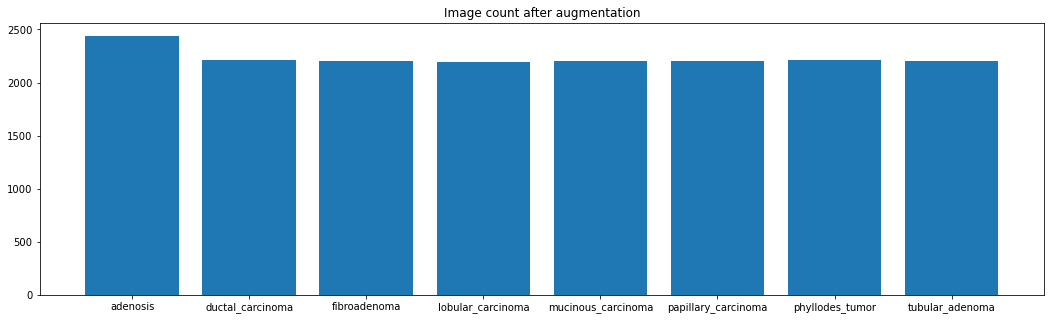

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,5))
plt.title("Image count after augmentation")
plt.bar(augmented_num_images.keys(),augmented_num_images.values())

# Build different models

## 1. Baseline model

First model: We will create a baseline model with the images that are normalized to the same scale and same size.

In this model we have 5 convolution blocks and maxpolling layer of 2x2 added to each layer. We used Relu as the activation function in each of these layers. We added a dense layer layer of 256 neuron with relu activation function. The final layer has 8 neurons as we have to classify eight different cancer types. The final layer has Softmax activation function.

In [1]:
from keras import models
from keras import layers
import timeit
from tensorflow.keras.models import Sequential

def build_model(optimizer,input_sz):
    
    try:
        del model
    except Exception:
        pass
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',padding="same",
                            input_shape=(input_sz, input_sz, 3)))
    model.add(layers.MaxPooling2D((2, 2)))   
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['acc'])
       
    return model

In [5]:
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# RMPSProp with lr=0.001, 30 epochs, 128 batch size
opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)

baseline_model = build_model(opt,input_sz)
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 256)      0

In [46]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator,validation_generator = data_generator(train_dir,validation_dir,train_datagen,validation_datagen)

Found 5061 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [99]:
# set a timer to measure training time
start = timeit.default_timer()
    
baseline_history = baseline_model.fit(train_generator,
                          steps_per_epoch=len_train//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

    
stop = timeit.default_timer()
print('Time: ', stop - start) 
    

# add the trained model to the list
#models.append(baseline_model)

Epoch 1/30
39/39 [==============================] - 90s 2s/step - loss: 2.8406 - acc: 0.3989 - val_loss: 1.6949 - val_acc: 0.4410
Epoch 2/30
39/39 [==============================] - 81s 2s/step - loss: 1.8448 - acc: 0.4166 - val_loss: 1.9634 - val_acc: 0.4531
Epoch 3/30
39/39 [==============================] - 82s 2s/step - loss: 1.7821 - acc: 0.4310 - val_loss: 1.6854 - val_acc: 0.4410
Epoch 4/30
39/39 [==============================] - 84s 2s/step - loss: 1.7082 - acc: 0.4391 - val_loss: 1.7260 - val_acc: 0.4401
Epoch 5/30
39/39 [==============================] - 82s 2s/step - loss: 1.6708 - acc: 0.4358 - val_loss: 1.6090 - val_acc: 0.4497
Epoch 6/30
39/39 [==============================] - 82s 2s/step - loss: 1.6416 - acc: 0.4500 - val_loss: 1.5607 - val_acc: 0.4757
Epoch 7/30
39/39 [==============================] - 81s 2s/step - loss: 1.5932 - acc: 0.4675 - val_loss: 1.5515 - val_acc: 0.4748
Epoch 8/30
39/39 [==============================] - 81s 2s/step - loss: 1.5844 - acc: 0.47

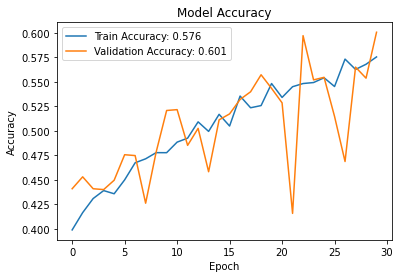

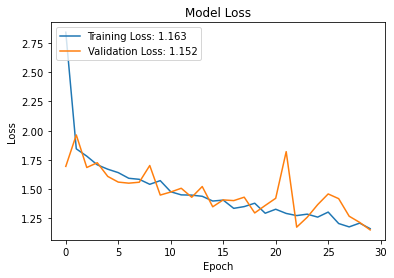

In [100]:
accuracy_loss_plot(baseline_history)

In [115]:
#Validate on test images
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size = len_test//batch_sz, 
            class_mode='categorical')
   

test_loss, test_acc = baseline_model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)
print('test loss:',test_loss)

Found 1582 images belonging to 8 classes.
50/50 [==============================] - 6s 111ms/step - loss: 1.1521 - acc: 0.5933
test acc: 0.5933333039283752
test loss: 1.1521176099777222



In this model, the accuracy is increasing and after adding the dropout layers, we were able to reduce the overfitting. Eventhough, the accuracy is only 57 % in test dataset, we might get a better accuracy if run the model for more epochs


In [102]:

#Confution Matrix and Classification Report
Y_pred = baseline_model.predict(test_generator, len_test // batch_sz+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Confusion Matrix
[[  4  47  17   3   5   7   1   5]
 [ 27 375 152  23  37  38   4  34]
 [  9 123  31  11  10   7   3   9]
 [  2  82  20   4   4   7   0   6]
 [  7  97  26   5   6   8   1   8]
 [  4  64  27   2   6   5   1   3]
 [  6  49  16   2   4   4   3   7]
 [  5  68  24   3   5   3   0   6]]
Classification Report
                     precision    recall  f1-score   support

           adenosis       0.06      0.04      0.05        89
   ductal_carcinoma       0.41      0.54      0.47       690
       fibroadenoma       0.10      0.15      0.12       203
  lobular_carcinoma       0.08      0.03      0.04       125
 mucinous_carcinoma       0.08      0.04      0.05       158
papillary_carcinoma       0.06      0.04      0.05       112
    phyllodes_tumor       0.23      0.03      0.06        91
    tubular_adenoma       0.08      0.05      0.06       114

           accuracy                           0.27      1582
          macro avg       0.14      0.12      0.11      1582
       


Looking at the classification report and confusion matrix, we can see that the F1 score is only 0.11. The confusion matrix clearly shows that only majority of images were classified as Ductal Carcinoma which has the highest number of images in  the original dataset. 


## 2. Baseline model with Data Augmentation 


We performed online augmentation to the image dataset based on the augmentation techniques mentioned earlier. Online augmentation augments the images in the dataset and makes sure that the training dataset doesn’t see the image more than once. The models built on online augmentation performed very poorly compared to raw data and balanced augmented data. We augmented the data with changes in rotation, width shift, zoom, horizontal flip and brightness.


In [42]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [103]:
# Augmentation

train_datagen = ImageDataGenerator(
                            rotation_range=20,
                            zoom_range=0.05,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode="nearest")

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


In [104]:
train_generator,validation_generator = data_generator(train_dir,validation_dir,train_datagen,validation_datagen)

Found 5061 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [105]:
# Optimizer as RMPSProp with lr=0.001, 30 epochs, 128 batch size
opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)

baseline_aug_model = build_model(opt,input_sz)
baseline_aug_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1628 (Conv2D)        (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_1629 (Conv2D)        (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_1630 (Conv2D)        (None, 35, 35, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 17, 17, 128)     

In [106]:
baseline_aug_history = baseline_aug_model.fit(train_generator,
                          steps_per_epoch=len_train//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

Epoch 1/30
39/39 [==============================] - 85s 2s/step - loss: 48.6893 - acc: 0.2939 - val_loss: 2.0455 - val_acc: 0.4358
Epoch 2/30
39/39 [==============================] - 82s 2s/step - loss: 2.1509 - acc: 0.3594 - val_loss: 2.0056 - val_acc: 0.4462
Epoch 3/30
39/39 [==============================] - 81s 2s/step - loss: 1.9704 - acc: 0.4170 - val_loss: 1.8622 - val_acc: 0.4418
Epoch 4/30
39/39 [==============================] - 80s 2s/step - loss: 2.9933 - acc: 0.4030 - val_loss: 1.7659 - val_acc: 0.4366
Epoch 5/30
39/39 [==============================] - 80s 2s/step - loss: 1.7604 - acc: 0.4362 - val_loss: 1.7644 - val_acc: 0.4340
Epoch 6/30
39/39 [==============================] - 81s 2s/step - loss: 1.8372 - acc: 0.4259 - val_loss: 1.7559 - val_acc: 0.4392
Epoch 7/30
39/39 [==============================] - 81s 2s/step - loss: 1.7648 - acc: 0.4354 - val_loss: 1.7594 - val_acc: 0.4358
Epoch 8/30
39/39 [==============================] - 81s 2s/step - loss: 1.7603 - acc: 0.4

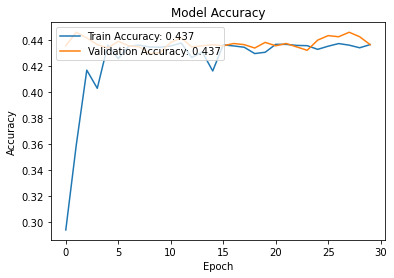

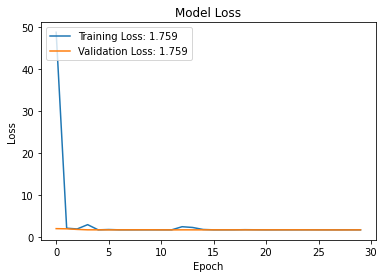

In [107]:
accuracy_loss_plot(baseline_aug_history)

In [118]:
#Validate on test images
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size = len_test//batch_sz, 
            class_mode='categorical')
   

test_loss, test_acc = baseline_aug_model.evaluate(test_generator, steps=len_test // batch_sz+1)
print('test acc:', test_acc)
print('test loss:',test_loss)

Found 1582 images belonging to 8 classes.
13/13 [==============================] - 1s 110ms/step - loss: 1.6524 - acc: 0.5000
test acc: 0.5
test loss: 1.6524181365966797


 
The accuracy is very low and we can see than the validation accuracy stands almost constant and is not improving at all. Also, the loss of both training and validation datasets are also remaining constant and is not decreasing 


In [109]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Confution Matrix and Classification Report
Y_pred = baseline_aug_model.predict(test_generator, len_test // batch_sz+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Confusion Matrix
[[  0  89   0   0   0   0   0   0]
 [  0 690   0   0   0   0   0   0]
 [  0 203   0   0   0   0   0   0]
 [  0 125   0   0   0   0   0   0]
 [  0 158   0   0   0   0   0   0]
 [  0 112   0   0   0   0   0   0]
 [  0  91   0   0   0   0   0   0]
 [  0 114   0   0   0   0   0   0]]
Classification Report
                     precision    recall  f1-score   support

           adenosis       0.00      0.00      0.00        89
   ductal_carcinoma       0.44      1.00      0.61       690
       fibroadenoma       0.00      0.00      0.00       203
  lobular_carcinoma       0.00      0.00      0.00       125
 mucinous_carcinoma       0.00      0.00      0.00       158
papillary_carcinoma       0.00      0.00      0.00       112
    phyllodes_tumor       0.00      0.00      0.00        91
    tubular_adenoma       0.00      0.00      0.00       114

           accuracy                           0.44      1582
          macro avg       0.05      0.12      0.08      1582
       

c:\Miniconda\envs\py38_default\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In this model , the classification report and confusion matrix shows that the F1 score is only 0.08. The confusion matrix clearly shows that only majority of images were classified as Ductal Carcinoma which has the highest number of images in  the original dataset. 

## 3. Baseline model with balanced augmented data

In [49]:
aug_train_datagen = ImageDataGenerator(rescale=1./255)


aug_train_generator,validation_generator = data_generator(train_augment_dir,
                                                          validation_dir,
                                                          aug_train_datagen,
                                                          validation_datagen)
test_datagen = ImageDataGenerator(rescale=1./255)


Found 17630 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [50]:
opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)

baseline_aug_model2 = build_model(opt,input_sz)
baseline_aug_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 35, 35, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [51]:
# set a timer to measure training time
start = timeit.default_timer()
    
baseline_aug_model2_history = baseline_aug_model2.fit(aug_train_generator,
                          steps_per_epoch=17630//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

    
stop = timeit.default_timer()
print('Time: ', stop - start) 
    

Epoch 1/30
137/137 [==============================] - 195s 1s/step - loss: 2.0167 - acc: 0.2008 - val_loss: 2.0746 - val_acc: 0.1493
Epoch 2/30
137/137 [==============================] - 79s 578ms/step - loss: 1.7923 - acc: 0.3051 - val_loss: 1.6592 - val_acc: 0.4401
Epoch 3/30
137/137 [==============================] - 80s 582ms/step - loss: 1.6442 - acc: 0.3734 - val_loss: 1.4036 - val_acc: 0.5226
Epoch 4/30
137/137 [==============================] - 80s 581ms/step - loss: 1.5087 - acc: 0.4355 - val_loss: 1.5158 - val_acc: 0.4375
Epoch 5/30
137/137 [==============================] - 80s 585ms/step - loss: 1.3944 - acc: 0.4836 - val_loss: 1.7617 - val_acc: 0.3446
Epoch 6/30
137/137 [==============================] - 80s 585ms/step - loss: 1.2745 - acc: 0.5269 - val_loss: 1.3055 - val_acc: 0.5330
Epoch 7/30
137/137 [==============================] - 81s 589ms/step - loss: 1.1886 - acc: 0.5606 - val_loss: 1.2468 - val_acc: 0.5451
Epoch 8/30
137/137 [==============================] - 80s

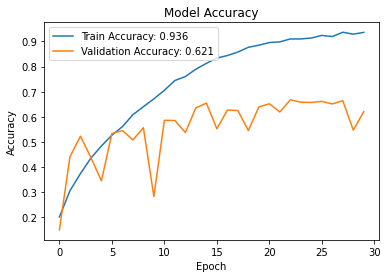

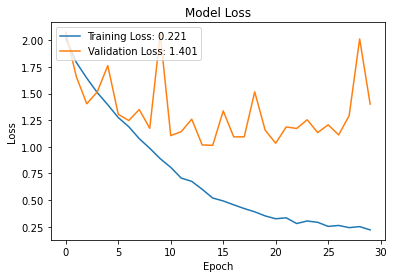

In [52]:
accuracy_loss_plot(baseline_aug_model2_history)

In [53]:
#Validate on test images
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size = len_test//batch_sz, 
            class_mode='categorical')
   

test_loss, test_acc = baseline_aug_model2.evaluate(test_generator, steps=50)
print('test acc:', test_acc)
print('test loss:',test_loss)

Found 1582 images belonging to 8 classes.
50/50 [==============================] - 8s 149ms/step - loss: 1.2674 - acc: 0.6783
test acc: 0.6783333420753479
test loss: 1.267371654510498


In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Confution Matrix and Classification Report
Y_pred = baseline_aug_model2.predict(test_generator, len_test // batch_sz+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Confusion Matrix
[[  1  52  19   5   2   6   2   2]
 [ 37 312 118  54  36  58  36  39]
 [  7  84  30  23  13  19  17  10]
 [  6  55  19   5  15  15   4   6]
 [  9  66  29  16  11  10   8   9]
 [  0  55  19  10   6   4   9   9]
 [  4  42  13  13   3   7   3   6]
 [  6  52  20  13   7   7   5   4]]
Classification Report
                     precision    recall  f1-score   support

           adenosis       0.01      0.01      0.01        89
   ductal_carcinoma       0.43      0.45      0.44       690
       fibroadenoma       0.11      0.15      0.13       203
  lobular_carcinoma       0.04      0.04      0.04       125
 mucinous_carcinoma       0.12      0.07      0.09       158
papillary_carcinoma       0.03      0.04      0.03       112
    phyllodes_tumor       0.04      0.03      0.03        91
    tubular_adenoma       0.05      0.04      0.04       114

           accuracy                           0.23      1582
          macro avg       0.10      0.10      0.10      1582
       

In [ ]:
baseline_aug_model2.fit('baseline_dense_aug_model2.h5')

## Pretrained Models


 Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database. In this case, we choose InceptionResNetV2 to be pre-defined model and use it to extract features from images. The basic building block of Inception-ResNet-V2 is called Residual Inception Block. Inception-ResNet-V2 is 164 layers deep and has an image input size of 299 × 299.  

### 4. InceptionResNetV2 


Based on InceptionResNetV2 model, a flatten layer is added on it to connect it with fully connected layers, followed by one dense layer using reLu as activation function with 256 neurons and one output layer using Softmax as activation function with 8 neurons. 


In [55]:
#Build a model from a pretrained model using transfer learning 
from tensorflow.keras.applications import InceptionResNetV2

def build_IncResNetV2_model(optimizer,input_sz):
    
    try:
        del model
    except Exception:
        pass
    
    IncResNetV2_conv_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(input_sz, input_sz, 3))
    
    model = Sequential()
    model.add(IncResNetV2_conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))
    
    IncResNetV2_conv_base.trainable = False
    
    model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['acc'])
       
    return model

In [56]:
#Optimizer as RMS Prop with lr = 0.001

opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)

IncResNetV2_model_1 = build_IncResNetV2_model(opt,input_sz)
IncResNetV2_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 13824)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3539200   
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 57,877,992
Trainable params: 3,541,256
Non-trainable params: 54,336,736
_________________________________________________________________


In [47]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator,validation_generator = data_generator(train_dir,validation_dir,train_datagen,validation_datagen)

Found 5061 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [57]:
# set a timer to measure training time
start = timeit.default_timer()
    
IncResNetV2_history_1 = IncResNetV2_model_1.fit(train_generator,
                          steps_per_epoch=len_train//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

    
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/30
39/39 [==============================] - 76s 2s/step - loss: 8.9227 - acc: 0.3225 - val_loss: 2.1626 - val_acc: 0.4253
Epoch 2/30
39/39 [==============================] - 57s 1s/step - loss: 1.9061 - acc: 0.4062 - val_loss: 2.4916 - val_acc: 0.1901
Epoch 3/30
39/39 [==============================] - 57s 1s/step - loss: 1.6854 - acc: 0.4462 - val_loss: 1.6354 - val_acc: 0.4792
Epoch 4/30
39/39 [==============================] - 57s 1s/step - loss: 1.5588 - acc: 0.4825 - val_loss: 1.4636 - val_acc: 0.4818
Epoch 5/30
39/39 [==============================] - 58s 1s/step - loss: 1.3771 - acc: 0.5358 - val_loss: 1.7147 - val_acc: 0.5017
Epoch 6/30
39/39 [==============================] - 58s 1s/step - loss: 1.3606 - acc: 0.5554 - val_loss: 1.4084 - val_acc: 0.5191
Epoch 7/30
39/39 [==============================] - 57s 1s/step - loss: 1.2287 - acc: 0.5826 - val_loss: 1.5373 - val_acc: 0.5035
Epoch 8/30
39/39 [==============================] - 57s 1s/step - loss: 1.0838 - acc: 0.63

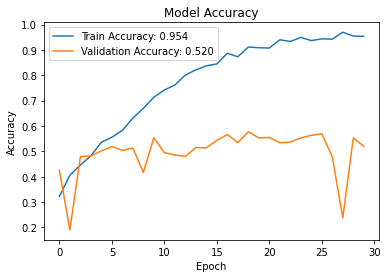

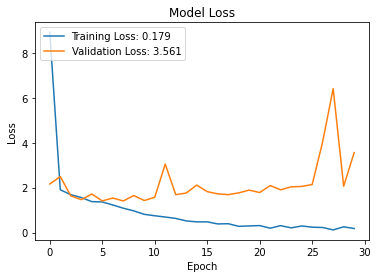

In [58]:
accuracy_loss_plot(IncResNetV2_history_1)

In [60]:
#Validate on test images
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size = len_test//batch_sz, 
            class_mode='categorical')
   

test_loss, test_acc = IncResNetV2_model_1.evaluate(test_generator, steps=50)
print('test acc:', test_acc)
print('test loss:',test_loss)

Found 1582 images belonging to 8 classes.
50/50 [==============================] - 7s 113ms/step - loss: 3.6437 - acc: 0.5250
test acc: 0.5249999761581421
test loss: 3.643684148788452


By using Inception ResNet V2 for feature extraction, we were not able to get very good test accuracy. Even though the training accuracy is about 95%, the validation and test accuracy are only around 52 %. So, the model showed a strong overfitting problem. 

In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Confution Matrix and Classification Report
Y_pred = IncResNetV2_model_1.predict(test_generator, len_test // batch_sz+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Confusion Matrix
[[  0  53   5   6  11   5   9   0]
 [  8 481  24  43  59  33  37   5]
 [  1 127  13  16  22  11  10   3]
 [  1  91   7   5   8   6   6   1]
 [  1 111   7   7  14   9   7   2]
 [  2  75   7   7   8   8   5   0]
 [  2  62   4   3  10   7   3   0]
 [  1  92   2   3  10   4   1   1]]
Classification Report
                     precision    recall  f1-score   support

           adenosis       0.00      0.00      0.00        89
   ductal_carcinoma       0.44      0.70      0.54       690
       fibroadenoma       0.19      0.06      0.10       203
  lobular_carcinoma       0.06      0.04      0.05       125
 mucinous_carcinoma       0.10      0.09      0.09       158
papillary_carcinoma       0.10      0.07      0.08       112
    phyllodes_tumor       0.04      0.03      0.04        91
    tubular_adenoma       0.08      0.01      0.02       114

           accuracy                           0.33      1582
          macro avg       0.13      0.13      0.11      1582
       

Looking at the classification report and confusion matrix of this model, we can see that the F1 score is only 0.11. The confusion matrix clearly shows that only majority of images were classified as Ductal Carcinoma which has the highest number of images in  the original dataset. 

## 5. InceptionResNetV2 with Adam optimizer and L1 regularizer

In [66]:
#Build a model from a pretrained model using transfer learning 
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
import timeit


def build_IncResNetV2_regularizer_model(optimizer,input_sz,kr):
    
    try:
        del model
    except Exception:
        pass
    
    IncResNetV2_conv_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(input_sz, input_sz, 3))
    
    model = Sequential()
    model.add(IncResNetV2_conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=kr))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=kr))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=kr))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=kr))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=kr))
    model.add(Dropout(0.25))
    model.add(layers.Dense(8, activation='softmax'))

    
    IncResNetV2_conv_base.trainable = False
    
    model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['acc'])
       
    return model
    
    

In [67]:
# Adam optimizer with lr=0.01 and L1 regularizer
opt=Adam(learning_rate=0.01)
kernel_reg = tf.keras.regularizers.L1(0.01)

IncResNetV2_model = build_IncResNetV2_regularizer_model(opt,input_sz,kernel_reg)
IncResNetV2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 13824)             0         
                                                                 
 dense_17 (Dense)            (None, 256)               3539200   
                                                                 
 dense_18 (Dense)            (None, 512)               131584    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                      

In [48]:
# Augmentation

train_datagen = ImageDataGenerator(
                            rotation_range=20,
                            zoom_range=0.05,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode="nearest")

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator,validation_generator = data_generator(train_dir,validation_dir,train_datagen,validation_datagen)



Found 5061 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [49]:
# set a timer to measure training time
start = timeit.default_timer()
    
IncResNetV2_history = IncResNetV2_model.fit(train_generator,
                          steps_per_epoch=len_train//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

    
stop = timeit.default_timer()
print('Time: ', stop - start) 
    

Epoch 1/30
39/39 [==============================] - 162s 3s/step - loss: 120.2772 - acc: 0.4198 - val_loss: 56.4832 - val_acc: 0.4306
Epoch 2/30
39/39 [==============================] - 85s 2s/step - loss: 50.9638 - acc: 0.4356 - val_loss: 47.9109 - val_acc: 0.4392
Epoch 3/30
39/39 [==============================] - 85s 2s/step - loss: 49.2328 - acc: 0.4391 - val_loss: 48.8440 - val_acc: 0.4444
Epoch 4/30
39/39 [==============================] - 83s 2s/step - loss: 49.2124 - acc: 0.4350 - val_loss: 47.7926 - val_acc: 0.4366
Epoch 5/30
39/39 [==============================] - 84s 2s/step - loss: 49.2201 - acc: 0.4354 - val_loss: 50.5714 - val_acc: 0.4271
Epoch 6/30
39/39 [==============================] - 83s 2s/step - loss: 49.3308 - acc: 0.4344 - val_loss: 47.8529 - val_acc: 0.4384
Epoch 7/30
39/39 [==============================] - 82s 2s/step - loss: 49.1406 - acc: 0.4369 - val_loss: 49.7332 - val_acc: 0.4384
Epoch 8/30
39/39 [==============================] - 83s 2s/step - loss: 49

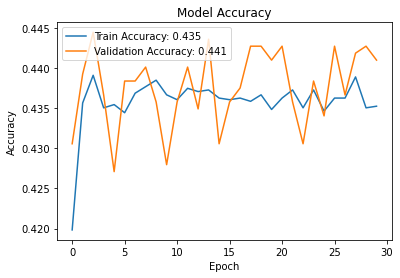

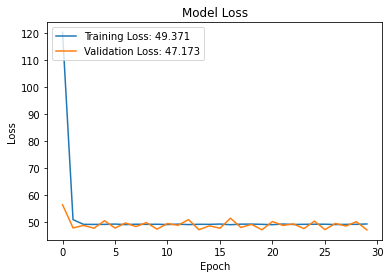

In [50]:
accuracy_loss_plot(IncResNetV2_history)

In [52]:
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size=batch_sz,
            class_mode='categorical')


Found 1582 images belonging to 8 classes.


In [53]:
test_loss,test_acc = IncResNetV2_model.evaluate(test_generator,steps = 50)
print("Test accuracy: ", test_acc)
print("Test Loss: ", test_loss)

50/50 [==============================] - 21s 397ms/step - loss: 47.1831 - acc: 0.4362
Test accuracy:  0.4361567497253418
Test Loss:  47.18305206298828


As the Inception Resnet V2 model showed overfitting on the online augmented dataset, we add dropout layers and included regularization methods to overcome overfitting.  

First we introduced L1 regularizer with lambda = 0.01 and droupout of 0.25. However, with this the model didn’t show a good performance. The overfitting problem was reduced, but the accuracy was also brought down. 

## InceptionResNetV2 with RMSProp optimizer and L2 regularizer


Next model was developed in Inception ResNet V2 with L2 regularizer with lambda 0.0001 and dropout of 0.5

In [71]:
# RMSPROP optimizer with lr=0.001 and Regularizer 

opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)
kernel_reg = tf.keras.regularizers.L2(0.0001)

IncResNetV2_model2 = build_IncResNetV2_regularizer_model(opt,input_sz,kernel_reg)
IncResNetV2_model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 13824)             0         
                                                                 
 dense_35 (Dense)            (None, 256)               3539200   
                                                                 
 dense_36 (Dense)            (None, 512)               131584    
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                      

In [49]:
# Augmentation

train_datagen = ImageDataGenerator(
                            rotation_range=20,
                            zoom_range=0.05,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode="nearest")

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator,validation_generator = data_generator(train_dir,validation_dir,train_datagen,validation_datagen)

Found 5061 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [72]:
# set a timer to measure training time
start = timeit.default_timer()
    
IncResNetV2_history2 = IncResNetV2_model2.fit(train_generator,
                          steps_per_epoch=len_train//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

    
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/30
39/39 [==============================] - 100s 2s/step - loss: 2.8253 - acc: 0.3868 - val_loss: 1.8090 - val_acc: 0.4479
Epoch 2/30
39/39 [==============================] - 82s 2s/step - loss: 1.8678 - acc: 0.4395 - val_loss: 1.6653 - val_acc: 0.4740
Epoch 3/30
39/39 [==============================] - 83s 2s/step - loss: 1.7413 - acc: 0.4541 - val_loss: 1.6274 - val_acc: 0.4783
Epoch 4/30
39/39 [==============================] - 84s 2s/step - loss: 1.6766 - acc: 0.4614 - val_loss: 1.5530 - val_acc: 0.4792
Epoch 5/30
39/39 [==============================] - 84s 2s/step - loss: 1.5920 - acc: 0.4808 - val_loss: 1.4875 - val_acc: 0.5009
Epoch 6/30
39/39 [==============================] - 83s 2s/step - loss: 1.5484 - acc: 0.4855 - val_loss: 1.6045 - val_acc: 0.4332
Epoch 7/30
39/39 [==============================] - 83s 2s/step - loss: 1.5062 - acc: 0.4879 - val_loss: 1.4788 - val_acc: 0.4965
Epoch 8/30
39/39 [==============================] - 83s 2s/step - loss: 1.4711 - acc: 0.4

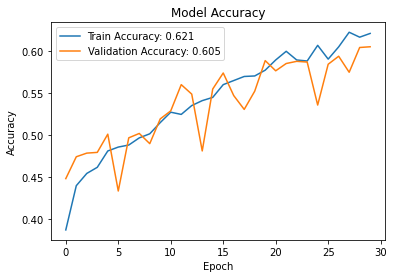

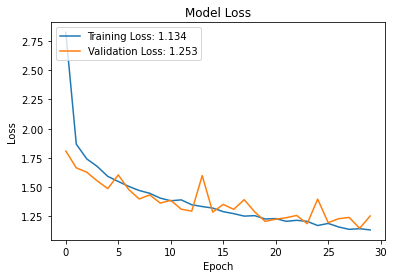

In [73]:
accuracy_loss_plot(IncResNetV2_history2)

In [113]:
#Validate on test images
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size = len_test//batch_sz, 
            class_mode='categorical')
   

test_loss, test_acc = IncResNetV2_model2.evaluate(test_generator, steps=len_test // batch_sz+1)
print('test acc:', test_acc)
print('test loss:',test_loss)

Found 1582 images belonging to 8 classes.
13/13 [==============================] - 2s 122ms/step - loss: 1.3376 - acc: 0.5897
test acc: 0.5897436141967773
test loss: 1.3376418352127075


With this we were able to reduce the overfitting problem and increase accuracy. As seen in the plot, the accuracy is increasing with the epochs. So, we believe the accuracy might increase if we train the model for more epochs. 

 

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Confution Matrix and Classification Report
Y_pred = IncResNetV2_model2.predict(test_generator, len_test // batch_sz+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Confusion Matrix
[[  2  58   9   3   2   2   0  13]
 [ 26 469  49   6  37  21   9  73]
 [  9 132  16   0  20   3   4  19]
 [  3  87   6   2  10   5   1  11]
 [ 12 109   7   0  13   3   4  10]
 [  3  82   5   0   4   2   3  13]
 [  3  66   6   1   7   3   0   5]
 [  5  90   2   1   3   2   2   9]]
Classification Report
                     precision    recall  f1-score   support

           adenosis       0.03      0.02      0.03        89
   ductal_carcinoma       0.43      0.68      0.53       690
       fibroadenoma       0.16      0.08      0.11       203
  lobular_carcinoma       0.15      0.02      0.03       125
 mucinous_carcinoma       0.14      0.08      0.10       158
papillary_carcinoma       0.05      0.02      0.03       112
    phyllodes_tumor       0.00      0.00      0.00        91
    tubular_adenoma       0.06      0.08      0.07       114

           accuracy                           0.32      1582
          macro avg       0.13      0.12      0.11      1582
       

Confusion matrix is similar to the previous models and our F1 score is very low. 

### InceptionResNetV2 on augmented balanced dataset with RMSProp Optimizer and L2 regularizer

Next we trained the Inception ResNet V2 model on augmented balanced dataset on L2 regularizer with lambda = 0.0001 and dropout = 0.5. 

In [91]:
aug_train_datagen = ImageDataGenerator(rescale=1./255)


aug_train_generator,validation_generator = data_generator(train_augment_dir,
                                                          validation_dir,
                                                          aug_train_datagen,
                                                          validation_datagen)
test_datagen = ImageDataGenerator(rescale=1./255)


Found 17631 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [92]:
opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)
kernel_reg = tf.keras.regularizers.L2(0.0001)

IncResNetV2_aug_model3 = build_IncResNetV2_regularizer_model(opt,input_sz,kernel_reg)
IncResNetV2_aug_model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 13824)             0         
                                                                 
 dense_41 (Dense)            (None, 256)               3539200   
                                                                 
 dense_42 (Dense)            (None, 512)               131584    
                                                                 
 dense_43 (Dense)            (None, 256)               131328    
                                                                 
 dense_44 (Dense)            (None, 128)               32896     
                                                      

In [93]:
# set a timer to measure training time
start = timeit.default_timer()
    
IncResNetV2_aug_history3 = IncResNetV2_aug_model3.fit(aug_train_generator,
                          steps_per_epoch=17632//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

    
stop = timeit.default_timer()
print('Time: ', stop - start) 
    

Epoch 1/30
137/137 [==============================] - 169s 1s/step - loss: 2.1941 - acc: 0.2512 - val_loss: 1.6455 - val_acc: 0.4288
Epoch 2/30
137/137 [==============================] - 95s 686ms/step - loss: 1.7005 - acc: 0.4035 - val_loss: 1.8816 - val_acc: 0.3689
Epoch 3/30
137/137 [==============================] - 94s 687ms/step - loss: 1.5292 - acc: 0.4668 - val_loss: 1.6390 - val_acc: 0.3967
Epoch 4/30
137/137 [==============================] - 95s 687ms/step - loss: 1.3671 - acc: 0.5321 - val_loss: 1.4032 - val_acc: 0.5217
Epoch 5/30
137/137 [==============================] - 95s 687ms/step - loss: 1.2392 - acc: 0.5812 - val_loss: 1.6391 - val_acc: 0.4766
Epoch 6/30
137/137 [==============================] - 95s 690ms/step - loss: 1.1427 - acc: 0.6225 - val_loss: 1.4797 - val_acc: 0.5234
Epoch 7/30
137/137 [==============================] - 95s 688ms/step - loss: 1.0506 - acc: 0.6561 - val_loss: 1.4225 - val_acc: 0.5694
Epoch 8/30
137/137 [==============================] - 95s

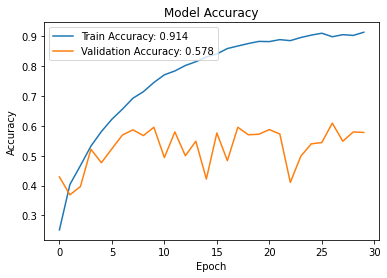

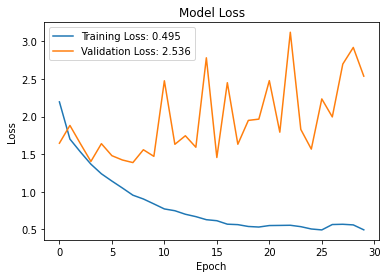

In [94]:
accuracy_loss_plot(IncResNetV2_aug_history3)

In [112]:
#Validate on test images
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size = len_test//batch_sz, 
            class_mode='categorical')
   

test_loss, test_acc = IncResNetV2_aug_model3.evaluate(test_generator, steps=len_test // batch_sz+1)
print('test acc:', test_acc)
print('test loss:',test_loss)

Found 1582 images belonging to 8 classes.
13/13 [==============================] - 2s 121ms/step - loss: 2.5033 - acc: 0.6218
test acc: 0.6217948794364929
test loss: 2.503261089324951


In this model we are getting a higher train accuracy of 91 % , but the model is showing strong overfitting problem.

In [ ]:

#Confution Matrix and Classification Report
Y_pred = IncResNetV2_aug_model3.predict(test_generator, len_test // batch_sz+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))


In this model also, the precision and F1 scores are too low.

 ### InceptionResNetV2 with augmented balanced data and L2(lambda=0.0001) Dropout(0.5) 

Next, we trained the InceptionResNet V2 model on augmented dataset with Regularizer as L2 with lambda of 0.0001 and dropout of 0.5

In [65]:
from keras.layers import Dropout

def build_IncResNetV2_regu_drpout_model(optimizer,input_sz,kr):
    
    try:
        del model
    except Exception:
        pass
    
    IncResNetV2_conv_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(input_sz, input_sz, 3))
    
    model = Sequential()
    model.add(IncResNetV2_conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=kr))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=kr))
    model.add(Dropout(0.5))
    model.add(layers.Dense(8, activation='softmax'))

    
    IncResNetV2_conv_base.trainable = False
    
    model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['acc'])
       
    return model
    

In [66]:
aug_train_datagen = ImageDataGenerator(rescale=1./255)


aug_train_generator,validation_generator = data_generator(train_augment_dir,
                                                          validation_dir,
                                                          aug_train_datagen,
                                                          validation_datagen)

test_datagen = ImageDataGenerator(rescale=1./255)


Found 17630 images belonging to 8 classes.
Found 1266 images belonging to 8 classes.


In [67]:
opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)
kernel_reg = tf.keras.regularizers.L2(0.0001)

IncResNetV2_aug_model4 = build_IncResNetV2_regu_drpout_model(opt,input_sz,kernel_reg)
IncResNetV2_aug_model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 13824)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               3539200   
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 1032      
                                                      

In [68]:
# set a timer to measure training time
start = timeit.default_timer()
    
IncResNetV2_aug_history4 = IncResNetV2_aug_model4.fit(aug_train_generator,
                          steps_per_epoch=17630//batch_sz,
                          epochs=epochs,
                          validation_data=validation_generator,
                          validation_steps=len_val//batch_sz)

    
stop = timeit.default_timer()
print('Time: ', stop - start) 
    

Epoch 1/30
137/137 [==============================] - 111s 727ms/step - loss: 2.9925 - acc: 0.1854 - val_loss: 1.7481 - val_acc: 0.4453
Epoch 2/30
137/137 [==============================] - 94s 685ms/step - loss: 2.0853 - acc: 0.2082 - val_loss: 1.8738 - val_acc: 0.2734
Epoch 3/30
137/137 [==============================] - 94s 683ms/step - loss: 1.9886 - acc: 0.2496 - val_loss: 1.7482 - val_acc: 0.3359
Epoch 4/30
137/137 [==============================] - 94s 681ms/step - loss: 1.8982 - acc: 0.2964 - val_loss: 1.7483 - val_acc: 0.3238
Epoch 5/30
137/137 [==============================] - 94s 681ms/step - loss: 1.8094 - acc: 0.3373 - val_loss: 1.8544 - val_acc: 0.3125
Epoch 6/30
137/137 [==============================] - 94s 682ms/step - loss: 1.7521 - acc: 0.3716 - val_loss: 1.5302 - val_acc: 0.4288
Epoch 7/30
137/137 [==============================] - 94s 683ms/step - loss: 1.6359 - acc: 0.4234 - val_loss: 1.4872 - val_acc: 0.5017
Epoch 8/30
137/137 [==============================] - 

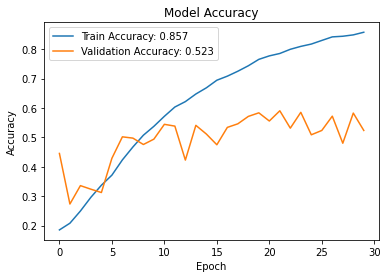

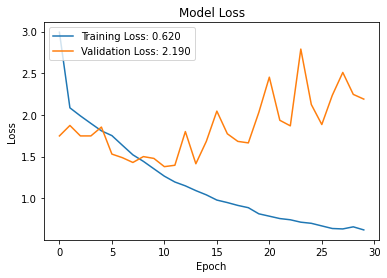

In [71]:
accuracy_loss_plot(IncResNetV2_aug_history4)

In [69]:
#Validate on test images
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(input_sz, input_sz),
            batch_size = len_test//batch_sz, 
            class_mode='categorical')
   

test_loss, test_acc = IncResNetV2_aug_model4.evaluate(test_generator, steps=len_test // batch_sz+1)
print('test acc:', test_acc)
print('test loss:',test_loss)

Found 1582 images belonging to 8 classes.
13/13 [==============================] - 2s 117ms/step - loss: 2.6640 - acc: 0.4936
test acc: 0.49358972907066345
test loss: 2.6639726161956787


The training and test accuracy reduced a little. However the overfitting still remained.

In [70]:

#Confution Matrix and Classification Report
Y_pred = IncResNetV2_aug_model4.predict(test_generator, len_test // batch_sz+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

Confusion Matrix
[[  3  26  11  10   8  18   5   8]
 [ 40 228 103  57  73 100  40  49]
 [ 17  65  29  13  24  34  11  10]
 [  9  37  23  16  10  20   3   7]
 [  5  60  35  11  14  17   2  14]
 [  5  39  21  10   9  15   7   6]
 [  9  35  11   6   8   9   5   8]
 [ 10  35  21   8   5  15  11   9]]
Classification Report
                     precision    recall  f1-score   support

           adenosis       0.03      0.03      0.03        89
   ductal_carcinoma       0.43      0.33      0.38       690
       fibroadenoma       0.11      0.14      0.13       203
  lobular_carcinoma       0.12      0.13      0.12       125
 mucinous_carcinoma       0.09      0.09      0.09       158
papillary_carcinoma       0.07      0.13      0.09       112
    phyllodes_tumor       0.06      0.05      0.06        91
    tubular_adenoma       0.08      0.08      0.08       114

           accuracy                           0.20      1582
          macro avg       0.13      0.12      0.12      1582
       

This model also didnt improve the F1 score and precision.

## Result 

### Comparison of accuracies of the various models:


#### We can conclude that a balanced augmented dataset gives a better accuracy than raw dataset and online augmented dataset. However, the F1 scores of all the models are too low and we need to find the right hyperparameters to tune the model in such a way that we reduce overfitting problem, without reducing the accuracy. 

 